In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric
import networkx as nx
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import TensorDataset

**Metrics and Utils**

In [258]:
def train_test_split(X, y, test_size):
    dataset_size = len(X)
    train_data_X = X[:int(dataset_size*(1-test_size))]
    test_data_X = X[int(dataset_size*(1-test_size)):]
    train_data_y = y[:int(dataset_size*(1-test_size))]
    test_data_y = y[int(dataset_size*(1-test_size)):]
    return train_data_X, test_data_X, train_data_y, test_data_y
    
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#custom sigmoid class with output between 0 and 255

def tsigmoid(x):
    return 255*torch.sigmoid(x/255)

class CustomSigmoidFunction(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__()

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return tsigmoid(input)

**Model**

In [193]:
#Model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class VAE(nn.Module):
    def __init__(self, batch_size):
        super(VAE, self).__init__()
        self.batch_size = batch_size

        #encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
        
        self.fc1 = nn.Linear(512*3*3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        
        self.fc31 = nn.Linear(1024, 512)
        self.fc32 = nn.Linear(1024, 512)
        
        #decoder
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.fc6 = nn.Linear(1024, 512*3*3)
        
        self.deconv1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1, output_padding=1)
        
        self.relu = nn.ReLU()
        self.sigmoid = CustomSigmoidFunction()
        self.sigmoid_1 = nn.Sigmoid()
        
    def encode(self, x):
        h1 = self.relu(self.conv1(x))
        #print("h1: :", h1.shape)
        h2 = self.relu(self.conv2(h1))
        #print("h2: :", h2.shape)
        h3 = self.relu(self.conv3(h2))
        #print("h3: :", h3.shape)
        h4 = self.relu(self.conv4(h3))
        #print("h4: :", h4.shape)
        h5 = self.relu(self.conv5(h4))
        #print("h5: :", h5.shape)
        h5 = h5.view(self.batch_size, 512*3*3)
        #print("h5: :", h5.shape)
        return self.relu(self.fc1(h5)), self.relu(self.fc1(h5))
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h1 = self.relu(self.fc6(z))
        #print("h1: :", h1.shape)
        h1 = h1.view(self.batch_size, 512, 3, 3)
        #print("h1: :", h1.shape)
        h2 = self.relu(self.deconv1(h1, output_size=torch.Size([self.batch_size,256,7,7])))
        #print("h2: :", h2.shape)
        h3 = self.relu(self.deconv2(h2))
        #print("h3: :", h3.shape)
        h4 = self.relu(self.deconv3(h3))
        #print("h4: :", h4.shape)
        h5 = self.relu(self.deconv4(h4, output_size=torch.Size([self.batch_size,self.batch_size,62,62])))
        #print("h5: :", h5.shape)
        h6 = self.deconv5(h5, output_size=torch.Size([self.batch_size,3,125,125]))
        #print("h6: :", h6.shape)
        #print(self.sigmoid(h6).shape)
        return_D = self.sigmoid_1(h6)
        return return_D
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 3, 125, 125))
        # mu, logvar = self.encode(x.view(-1, 125, 125, 3))
        z = self.reparameterize(mu, logvar)
        return self.decode(z).view(-1, 125, 125, 3), mu, logvar

**Load Data**

In [4]:
#read hdf5 file
f = h5py.File('/hdfs1/Data/Shrutimoy/quark-gluon_data-set_n139306.hdf5', 'r')


In [5]:
X_jets = np.asarray(f['X_jets'])
m0 = np.asarray(f['m0'])
pt = np.asarray(f['pt'])
y = np.asarray(f['y'])

In [146]:
#split X_jets and y into training, validation and test sets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_train_X, data_test_X, data_train_y, data_test_y = train_test_split(X_jets, y, test_size=0.1)
data_train_X, data_val_X, data_train_y, data_val_y = train_test_split(data_train_X, data_train_y, test_size=0.2)

#initialize the dataloaders with batches of 32
train_dataset = TensorDataset(torch.from_numpy(data_train_X).float(), torch.from_numpy(data_train_y).float())
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = TensorDataset(torch.from_numpy(data_val_X).float(), torch.from_numpy(data_val_y).float())
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_dataset = TensorDataset(torch.from_numpy(data_test_X).float(), torch.from_numpy(data_test_y).float())
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

**Model Initialization**

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [294]:
#VAE model
model = VAE(batch_size=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [295]:
loss_train, loss_test, loss_val = [], [], []
#traing loop
def train():
    model.train()
    train_loss = 0
    for (data, _) in tqdm(train_dataloader):
        data = data.cpu().numpy()
        data = (data - data.mean())/data.std()
        data = torch.from_numpy(data)
        data = torch.clamp(data, 0, 1)
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss/len(train_dataloader.dataset)
    
    
#validation loop
def validation():
    model.eval()
    val_loss = 0
    for (data, _) in tqdm(val_dataloader):
        data = data.cpu().numpy()
        data = (data - data.mean())/data.std()
        data = torch.from_numpy(data)
        data = torch.clamp(data, 0, 1)
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        val_loss += loss.item()
    return val_loss/len(val_dataloader.dataset)

    
#validation loop
def test():
    model.eval()
    test_loss = 0
    for (data, _) in tqdm(test_dataloader):
        data = data.cpu().numpy()
        data = (data - data.mean())/data.std()
        data = torch.from_numpy(data)
        data = torch.clamp(data, 0, 1)
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.item()
    return test_loss/len(test_dataloader.dataset)

#training loop
for epoch in range(200):
    train_loss = train()
    val_loss = validation()
    test_loss = test()
    #scheduler.step()
    print('====> Epoch: {} Train loss: {:.4f}'.format(
          epoch+1, train_loss))
    print('====> Epoch: {} Validation loss: {:.4f}'.format(
          epoch+1, val_loss))
    print('====> Epoch: {} Test loss: {:.4f}'.format(
            epoch+1, test_loss))
    loss_train.append(train_loss)
    loss_test.append(test_loss)
    loss_val.append(val_loss)

100%|██████████| 435/435 [00:05<00:00, 76.84it/s]


====> Epoch: 1 Train loss: 1716.4252
====> Epoch: 1 Validation loss: 1554.2302
====> Epoch: 1 Test loss: 1559.3026


100%|██████████| 435/435 [00:05<00:00, 77.62it/s]


====> Epoch: 2 Train loss: 1453.1559
====> Epoch: 2 Validation loss: 1530.2448
====> Epoch: 2 Test loss: 1534.5593


100%|██████████| 435/435 [00:05<00:00, 78.01it/s]


====> Epoch: 3 Train loss: 1435.2248
====> Epoch: 3 Validation loss: 1516.6960
====> Epoch: 3 Test loss: 1521.8384


100%|██████████| 435/435 [00:05<00:00, 77.31it/s]


====> Epoch: 4 Train loss: 1425.8266
====> Epoch: 4 Validation loss: 1508.7455
====> Epoch: 4 Test loss: 1513.0163


100%|██████████| 435/435 [00:05<00:00, 77.61it/s]


====> Epoch: 5 Train loss: 1419.8365
====> Epoch: 5 Validation loss: 1504.4980
====> Epoch: 5 Test loss: 1508.9161


100%|██████████| 435/435 [00:05<00:00, 77.78it/s]


====> Epoch: 6 Train loss: 1413.9160
====> Epoch: 6 Validation loss: 1498.9426
====> Epoch: 6 Test loss: 1503.2447


100%|██████████| 435/435 [00:05<00:00, 77.97it/s]


====> Epoch: 7 Train loss: 1410.4385
====> Epoch: 7 Validation loss: 1495.6653
====> Epoch: 7 Test loss: 1499.7778


100%|██████████| 435/435 [00:05<00:00, 77.63it/s]


====> Epoch: 8 Train loss: 1406.6578
====> Epoch: 8 Validation loss: 1495.0925
====> Epoch: 8 Test loss: 1499.7555


100%|██████████| 435/435 [00:05<00:00, 77.60it/s]


====> Epoch: 9 Train loss: 1405.0521
====> Epoch: 9 Validation loss: 1491.6733
====> Epoch: 9 Test loss: 1496.0200


100%|██████████| 435/435 [00:05<00:00, 76.35it/s]


====> Epoch: 10 Train loss: 1402.2807
====> Epoch: 10 Validation loss: 1488.3436
====> Epoch: 10 Test loss: 1493.0308


100%|██████████| 435/435 [00:05<00:00, 76.55it/s]


====> Epoch: 11 Train loss: 1399.8976
====> Epoch: 11 Validation loss: 1485.9574
====> Epoch: 11 Test loss: 1489.9689


100%|██████████| 435/435 [00:05<00:00, 76.94it/s]


====> Epoch: 12 Train loss: 1397.2348
====> Epoch: 12 Validation loss: 1484.3140
====> Epoch: 12 Test loss: 1488.1799


100%|██████████| 435/435 [00:05<00:00, 76.24it/s]


====> Epoch: 13 Train loss: 1395.6174
====> Epoch: 13 Validation loss: 1482.3384
====> Epoch: 13 Test loss: 1486.7077


100%|██████████| 435/435 [00:05<00:00, 76.96it/s]


====> Epoch: 14 Train loss: 1394.1302
====> Epoch: 14 Validation loss: 1480.0383
====> Epoch: 14 Test loss: 1484.5849


100%|██████████| 435/435 [00:05<00:00, 76.21it/s]


====> Epoch: 15 Train loss: 1392.2521
====> Epoch: 15 Validation loss: 1478.5170
====> Epoch: 15 Test loss: 1483.0521


100%|██████████| 435/435 [00:05<00:00, 76.89it/s]


====> Epoch: 16 Train loss: 1390.2279
====> Epoch: 16 Validation loss: 1477.3237
====> Epoch: 16 Test loss: 1481.7731


100%|██████████| 435/435 [00:05<00:00, 76.78it/s]


====> Epoch: 17 Train loss: 1388.0396
====> Epoch: 17 Validation loss: 1475.9679
====> Epoch: 17 Test loss: 1480.7903


100%|██████████| 435/435 [00:05<00:00, 77.26it/s]


====> Epoch: 18 Train loss: 1386.4016
====> Epoch: 18 Validation loss: 1473.1711
====> Epoch: 18 Test loss: 1477.3196


100%|██████████| 435/435 [00:05<00:00, 77.63it/s]


====> Epoch: 19 Train loss: 1384.5384
====> Epoch: 19 Validation loss: 1471.7941
====> Epoch: 19 Test loss: 1476.6921


100%|██████████| 435/435 [00:05<00:00, 75.57it/s]


====> Epoch: 20 Train loss: 1382.9543
====> Epoch: 20 Validation loss: 1472.1702
====> Epoch: 20 Test loss: 1476.1946


100%|██████████| 435/435 [00:05<00:00, 77.56it/s]


====> Epoch: 21 Train loss: 1382.2715
====> Epoch: 21 Validation loss: 1469.7479
====> Epoch: 21 Test loss: 1473.3620


100%|██████████| 435/435 [00:05<00:00, 76.98it/s]


====> Epoch: 22 Train loss: 1380.2496
====> Epoch: 22 Validation loss: 1469.2581
====> Epoch: 22 Test loss: 1473.6915


100%|██████████| 435/435 [00:05<00:00, 77.48it/s]


====> Epoch: 23 Train loss: 1378.4976
====> Epoch: 23 Validation loss: 1470.0304
====> Epoch: 23 Test loss: 1474.5871


100%|██████████| 435/435 [00:05<00:00, 77.34it/s]


====> Epoch: 24 Train loss: 1377.2586
====> Epoch: 24 Validation loss: 1465.7707
====> Epoch: 24 Test loss: 1470.6101


100%|██████████| 435/435 [00:05<00:00, 77.35it/s]


====> Epoch: 25 Train loss: 1376.1271
====> Epoch: 25 Validation loss: 1463.4562
====> Epoch: 25 Test loss: 1467.6185


100%|██████████| 435/435 [00:05<00:00, 77.38it/s]


====> Epoch: 26 Train loss: 1374.9355
====> Epoch: 26 Validation loss: 1463.0983
====> Epoch: 26 Test loss: 1466.8148


100%|██████████| 435/435 [00:05<00:00, 77.87it/s]


====> Epoch: 27 Train loss: 1372.7830
====> Epoch: 27 Validation loss: 1461.3529
====> Epoch: 27 Test loss: 1466.2041


100%|██████████| 435/435 [00:05<00:00, 77.70it/s]


====> Epoch: 28 Train loss: 1372.3321
====> Epoch: 28 Validation loss: 1460.7309
====> Epoch: 28 Test loss: 1465.3235


100%|██████████| 435/435 [00:05<00:00, 77.41it/s]


====> Epoch: 29 Train loss: 1370.6236
====> Epoch: 29 Validation loss: 1460.3723
====> Epoch: 29 Test loss: 1465.0348


100%|██████████| 435/435 [00:05<00:00, 77.54it/s]


====> Epoch: 30 Train loss: 1369.5827
====> Epoch: 30 Validation loss: 1458.7101
====> Epoch: 30 Test loss: 1463.0314


100%|██████████| 435/435 [00:05<00:00, 77.04it/s]


====> Epoch: 31 Train loss: 1368.8847
====> Epoch: 31 Validation loss: 1460.0011
====> Epoch: 31 Test loss: 1464.5175


100%|██████████| 435/435 [00:05<00:00, 76.69it/s]


====> Epoch: 32 Train loss: 1367.9318
====> Epoch: 32 Validation loss: 1457.0660
====> Epoch: 32 Test loss: 1460.9398


100%|██████████| 435/435 [00:05<00:00, 76.79it/s]


====> Epoch: 33 Train loss: 1366.6004
====> Epoch: 33 Validation loss: 1455.1418
====> Epoch: 33 Test loss: 1459.1878


100%|██████████| 435/435 [00:05<00:00, 76.95it/s]


====> Epoch: 34 Train loss: 1365.6211
====> Epoch: 34 Validation loss: 1454.6951
====> Epoch: 34 Test loss: 1460.2641


100%|██████████| 435/435 [00:05<00:00, 77.00it/s]


====> Epoch: 35 Train loss: 1365.6321
====> Epoch: 35 Validation loss: 1454.3520
====> Epoch: 35 Test loss: 1459.0950


100%|██████████| 435/435 [00:05<00:00, 77.03it/s]


====> Epoch: 36 Train loss: 1363.6637
====> Epoch: 36 Validation loss: 1453.7879
====> Epoch: 36 Test loss: 1458.1016


100%|██████████| 435/435 [00:05<00:00, 77.12it/s]


====> Epoch: 37 Train loss: 1364.1390
====> Epoch: 37 Validation loss: 1452.6429
====> Epoch: 37 Test loss: 1456.9269


100%|██████████| 435/435 [00:05<00:00, 77.04it/s]


====> Epoch: 38 Train loss: 1363.3746
====> Epoch: 38 Validation loss: 1451.8705
====> Epoch: 38 Test loss: 1456.9749


100%|██████████| 435/435 [00:05<00:00, 76.30it/s]


====> Epoch: 39 Train loss: 1362.3661
====> Epoch: 39 Validation loss: 1451.4991
====> Epoch: 39 Test loss: 1455.8981


100%|██████████| 435/435 [00:05<00:00, 77.12it/s]


====> Epoch: 40 Train loss: 1361.5509
====> Epoch: 40 Validation loss: 1450.0962
====> Epoch: 40 Test loss: 1454.8481


100%|██████████| 435/435 [00:05<00:00, 76.72it/s]


====> Epoch: 41 Train loss: 1360.7083
====> Epoch: 41 Validation loss: 1449.1832
====> Epoch: 41 Test loss: 1453.3672


100%|██████████| 435/435 [00:05<00:00, 76.97it/s]


====> Epoch: 42 Train loss: 1360.5588
====> Epoch: 42 Validation loss: 1449.7689
====> Epoch: 42 Test loss: 1454.3947


100%|██████████| 435/435 [00:05<00:00, 76.91it/s]


====> Epoch: 43 Train loss: 1359.2971
====> Epoch: 43 Validation loss: 1448.7203
====> Epoch: 43 Test loss: 1453.4641


100%|██████████| 435/435 [00:05<00:00, 77.02it/s]


====> Epoch: 44 Train loss: 1358.5766
====> Epoch: 44 Validation loss: 1448.2421
====> Epoch: 44 Test loss: 1452.6208


100%|██████████| 435/435 [00:05<00:00, 76.86it/s]


====> Epoch: 45 Train loss: 1358.2721
====> Epoch: 45 Validation loss: 1450.7446
====> Epoch: 45 Test loss: 1455.1284


100%|██████████| 435/435 [00:05<00:00, 76.73it/s]


====> Epoch: 46 Train loss: 1358.0107
====> Epoch: 46 Validation loss: 1447.8124
====> Epoch: 46 Test loss: 1452.2821


100%|██████████| 435/435 [00:05<00:00, 76.97it/s]


====> Epoch: 47 Train loss: 1357.2841
====> Epoch: 47 Validation loss: 1446.6787
====> Epoch: 47 Test loss: 1450.9517


100%|██████████| 435/435 [00:05<00:00, 77.26it/s]


====> Epoch: 48 Train loss: 1357.5866
====> Epoch: 48 Validation loss: 1446.6096
====> Epoch: 48 Test loss: 1450.6895


100%|██████████| 435/435 [00:05<00:00, 76.47it/s]


====> Epoch: 49 Train loss: 1356.3074
====> Epoch: 49 Validation loss: 1445.6700
====> Epoch: 49 Test loss: 1450.2881


100%|██████████| 435/435 [00:05<00:00, 76.85it/s]


====> Epoch: 50 Train loss: 1355.5328
====> Epoch: 50 Validation loss: 1445.8569
====> Epoch: 50 Test loss: 1450.3810


100%|██████████| 435/435 [00:05<00:00, 76.63it/s]


====> Epoch: 51 Train loss: 1355.6236
====> Epoch: 51 Validation loss: 1445.7474
====> Epoch: 51 Test loss: 1450.4416


100%|██████████| 435/435 [00:05<00:00, 76.91it/s]


====> Epoch: 52 Train loss: 1354.7252
====> Epoch: 52 Validation loss: 1444.6453
====> Epoch: 52 Test loss: 1448.9355


100%|██████████| 435/435 [00:05<00:00, 77.00it/s]


====> Epoch: 53 Train loss: 1355.0139
====> Epoch: 53 Validation loss: 1444.1313
====> Epoch: 53 Test loss: 1448.3951


100%|██████████| 435/435 [00:05<00:00, 77.04it/s]


====> Epoch: 54 Train loss: 1354.2522
====> Epoch: 54 Validation loss: 1443.3052
====> Epoch: 54 Test loss: 1447.9819


100%|██████████| 435/435 [00:05<00:00, 76.66it/s]


====> Epoch: 55 Train loss: 1354.5987
====> Epoch: 55 Validation loss: 1442.8942
====> Epoch: 55 Test loss: 1447.1638


100%|██████████| 435/435 [00:05<00:00, 76.49it/s]


====> Epoch: 56 Train loss: 1354.0488
====> Epoch: 56 Validation loss: 1442.9618
====> Epoch: 56 Test loss: 1447.7306


100%|██████████| 435/435 [00:05<00:00, 76.86it/s]


====> Epoch: 57 Train loss: 1353.9044
====> Epoch: 57 Validation loss: 1442.2656
====> Epoch: 57 Test loss: 1446.9743


100%|██████████| 435/435 [00:05<00:00, 76.78it/s]


====> Epoch: 58 Train loss: 1353.4827
====> Epoch: 58 Validation loss: 1442.2694
====> Epoch: 58 Test loss: 1446.5755


100%|██████████| 435/435 [00:05<00:00, 76.91it/s]


====> Epoch: 59 Train loss: 1353.2582
====> Epoch: 59 Validation loss: 1442.0284
====> Epoch: 59 Test loss: 1446.1930


100%|██████████| 435/435 [00:05<00:00, 76.55it/s]


====> Epoch: 60 Train loss: 1351.9854
====> Epoch: 60 Validation loss: 1441.5978
====> Epoch: 60 Test loss: 1446.2394


100%|██████████| 435/435 [00:05<00:00, 76.82it/s]


====> Epoch: 61 Train loss: 1352.1525
====> Epoch: 61 Validation loss: 1441.7991
====> Epoch: 61 Test loss: 1446.1858


100%|██████████| 435/435 [00:05<00:00, 76.89it/s]


====> Epoch: 62 Train loss: 1352.0540
====> Epoch: 62 Validation loss: 1440.7668
====> Epoch: 62 Test loss: 1445.0694


100%|██████████| 435/435 [00:05<00:00, 77.05it/s]


====> Epoch: 63 Train loss: 1350.9804
====> Epoch: 63 Validation loss: 1441.3185
====> Epoch: 63 Test loss: 1445.5257


100%|██████████| 435/435 [00:05<00:00, 76.49it/s]


====> Epoch: 64 Train loss: 1351.2671
====> Epoch: 64 Validation loss: 1439.8727
====> Epoch: 64 Test loss: 1444.2938


100%|██████████| 435/435 [00:05<00:00, 75.63it/s]


====> Epoch: 65 Train loss: 1351.3544
====> Epoch: 65 Validation loss: 1440.4887
====> Epoch: 65 Test loss: 1444.7870


100%|██████████| 435/435 [00:05<00:00, 76.65it/s]


====> Epoch: 66 Train loss: 1350.3020
====> Epoch: 66 Validation loss: 1441.2012
====> Epoch: 66 Test loss: 1445.3132


100%|██████████| 435/435 [00:05<00:00, 76.74it/s]


====> Epoch: 67 Train loss: 1351.1968
====> Epoch: 67 Validation loss: 1439.6021
====> Epoch: 67 Test loss: 1444.0050


100%|██████████| 435/435 [00:05<00:00, 77.02it/s]


====> Epoch: 68 Train loss: 1350.3187
====> Epoch: 68 Validation loss: 1441.5888
====> Epoch: 68 Test loss: 1445.7967


100%|██████████| 435/435 [00:05<00:00, 75.26it/s]


====> Epoch: 69 Train loss: 1350.0194
====> Epoch: 69 Validation loss: 1439.7868
====> Epoch: 69 Test loss: 1443.5089


100%|██████████| 435/435 [00:05<00:00, 77.53it/s]


====> Epoch: 70 Train loss: 1350.0294
====> Epoch: 70 Validation loss: 1439.7261
====> Epoch: 70 Test loss: 1443.7820


100%|██████████| 435/435 [00:05<00:00, 76.67it/s]


====> Epoch: 71 Train loss: 1350.0668
====> Epoch: 71 Validation loss: 1439.6028
====> Epoch: 71 Test loss: 1443.5303


100%|██████████| 435/435 [00:05<00:00, 76.70it/s]


====> Epoch: 72 Train loss: 1349.3623
====> Epoch: 72 Validation loss: 1439.8237
====> Epoch: 72 Test loss: 1443.4163


100%|██████████| 435/435 [00:05<00:00, 76.84it/s]


====> Epoch: 73 Train loss: 1348.6735
====> Epoch: 73 Validation loss: 1439.7174
====> Epoch: 73 Test loss: 1444.6531


100%|██████████| 435/435 [00:05<00:00, 77.55it/s]


====> Epoch: 74 Train loss: 1349.0041
====> Epoch: 74 Validation loss: 1438.8500
====> Epoch: 74 Test loss: 1442.9541


100%|██████████| 435/435 [00:05<00:00, 77.16it/s]


====> Epoch: 75 Train loss: 1348.6329
====> Epoch: 75 Validation loss: 1438.2412
====> Epoch: 75 Test loss: 1442.5110


100%|██████████| 435/435 [00:05<00:00, 76.90it/s]


====> Epoch: 76 Train loss: 1348.2693
====> Epoch: 76 Validation loss: 1438.9177
====> Epoch: 76 Test loss: 1442.9667


100%|██████████| 435/435 [00:05<00:00, 76.85it/s]


====> Epoch: 77 Train loss: 1348.2916
====> Epoch: 77 Validation loss: 1438.4841
====> Epoch: 77 Test loss: 1442.6950


100%|██████████| 435/435 [00:05<00:00, 76.58it/s]


====> Epoch: 78 Train loss: 1348.1366
====> Epoch: 78 Validation loss: 1437.5250
====> Epoch: 78 Test loss: 1442.2476


100%|██████████| 435/435 [00:05<00:00, 76.41it/s]


====> Epoch: 79 Train loss: 1347.6862
====> Epoch: 79 Validation loss: 1437.4677
====> Epoch: 79 Test loss: 1442.6560


100%|██████████| 435/435 [00:05<00:00, 76.50it/s]


====> Epoch: 80 Train loss: 1347.6433
====> Epoch: 80 Validation loss: 1437.6598
====> Epoch: 80 Test loss: 1442.3238


100%|██████████| 435/435 [00:05<00:00, 76.49it/s]


====> Epoch: 81 Train loss: 1347.7147
====> Epoch: 81 Validation loss: 1436.1134
====> Epoch: 81 Test loss: 1441.3498


100%|██████████| 435/435 [00:05<00:00, 76.96it/s]


====> Epoch: 82 Train loss: 1347.3964
====> Epoch: 82 Validation loss: 1437.0522
====> Epoch: 82 Test loss: 1440.9385


100%|██████████| 435/435 [00:05<00:00, 76.67it/s]


====> Epoch: 83 Train loss: 1346.6653
====> Epoch: 83 Validation loss: 1436.1284
====> Epoch: 83 Test loss: 1441.1508


100%|██████████| 435/435 [00:05<00:00, 77.05it/s]


====> Epoch: 84 Train loss: 1346.9713
====> Epoch: 84 Validation loss: 1437.0375
====> Epoch: 84 Test loss: 1440.9937


100%|██████████| 435/435 [00:05<00:00, 77.61it/s]


====> Epoch: 85 Train loss: 1347.1024
====> Epoch: 85 Validation loss: 1436.0290
====> Epoch: 85 Test loss: 1440.5716


100%|██████████| 435/435 [00:05<00:00, 77.55it/s]


====> Epoch: 86 Train loss: 1346.7828
====> Epoch: 86 Validation loss: 1435.9426
====> Epoch: 86 Test loss: 1441.0072


100%|██████████| 435/435 [00:05<00:00, 77.70it/s]


====> Epoch: 87 Train loss: 1346.4030
====> Epoch: 87 Validation loss: 1436.7060
====> Epoch: 87 Test loss: 1441.4304


100%|██████████| 435/435 [00:05<00:00, 77.41it/s]


====> Epoch: 88 Train loss: 1346.3774
====> Epoch: 88 Validation loss: 1436.6067
====> Epoch: 88 Test loss: 1441.0365


100%|██████████| 435/435 [00:05<00:00, 77.64it/s]


====> Epoch: 89 Train loss: 1345.3860
====> Epoch: 89 Validation loss: 1438.8872
====> Epoch: 89 Test loss: 1442.3225


100%|██████████| 435/435 [00:05<00:00, 77.76it/s]


====> Epoch: 90 Train loss: 1345.8525
====> Epoch: 90 Validation loss: 1436.0419
====> Epoch: 90 Test loss: 1440.9146


100%|██████████| 435/435 [00:05<00:00, 77.90it/s]


====> Epoch: 91 Train loss: 1345.1768
====> Epoch: 91 Validation loss: 1434.7900
====> Epoch: 91 Test loss: 1438.8024


100%|██████████| 435/435 [00:05<00:00, 77.61it/s]


====> Epoch: 92 Train loss: 1345.2467
====> Epoch: 92 Validation loss: 1435.4853
====> Epoch: 92 Test loss: 1439.7143


100%|██████████| 435/435 [00:05<00:00, 77.49it/s]


====> Epoch: 93 Train loss: 1346.0061
====> Epoch: 93 Validation loss: 1434.9570
====> Epoch: 93 Test loss: 1439.3726


100%|██████████| 435/435 [00:05<00:00, 77.51it/s]


====> Epoch: 94 Train loss: 1345.2285
====> Epoch: 94 Validation loss: 1436.3878
====> Epoch: 94 Test loss: 1440.4978


100%|██████████| 435/435 [00:05<00:00, 77.54it/s]


====> Epoch: 95 Train loss: 1345.1976
====> Epoch: 95 Validation loss: 1435.1152
====> Epoch: 95 Test loss: 1439.0610


100%|██████████| 435/435 [00:05<00:00, 77.61it/s]


====> Epoch: 96 Train loss: 1345.4370
====> Epoch: 96 Validation loss: 1434.8409
====> Epoch: 96 Test loss: 1439.1543


100%|██████████| 435/435 [00:05<00:00, 74.33it/s]


====> Epoch: 97 Train loss: 1344.6368
====> Epoch: 97 Validation loss: 1434.6341
====> Epoch: 97 Test loss: 1438.9590


100%|██████████| 435/435 [00:05<00:00, 77.59it/s]


====> Epoch: 98 Train loss: 1344.2309
====> Epoch: 98 Validation loss: 1436.2706
====> Epoch: 98 Test loss: 1440.0277


100%|██████████| 435/435 [00:05<00:00, 77.42it/s]


====> Epoch: 99 Train loss: 1344.4027
====> Epoch: 99 Validation loss: 1434.4291
====> Epoch: 99 Test loss: 1438.3327


100%|██████████| 435/435 [00:05<00:00, 77.35it/s]


====> Epoch: 100 Train loss: 1344.3855
====> Epoch: 100 Validation loss: 1435.3282
====> Epoch: 100 Test loss: 1439.7888


100%|██████████| 435/435 [00:05<00:00, 77.58it/s]


====> Epoch: 101 Train loss: 1343.6966
====> Epoch: 101 Validation loss: 1435.9552
====> Epoch: 101 Test loss: 1440.0190


100%|██████████| 435/435 [00:05<00:00, 77.64it/s]


====> Epoch: 102 Train loss: 1343.7154
====> Epoch: 102 Validation loss: 1433.7621
====> Epoch: 102 Test loss: 1438.1869


100%|██████████| 435/435 [00:05<00:00, 77.65it/s]


====> Epoch: 103 Train loss: 1344.2495
====> Epoch: 103 Validation loss: 1435.0573
====> Epoch: 103 Test loss: 1439.7823


100%|██████████| 435/435 [00:05<00:00, 77.68it/s]


====> Epoch: 104 Train loss: 1343.7402
====> Epoch: 104 Validation loss: 1434.8322
====> Epoch: 104 Test loss: 1438.8426


100%|██████████| 435/435 [00:05<00:00, 77.38it/s]


====> Epoch: 105 Train loss: 1343.6167
====> Epoch: 105 Validation loss: 1433.5726
====> Epoch: 105 Test loss: 1438.0138


100%|██████████| 435/435 [00:05<00:00, 77.60it/s]


====> Epoch: 106 Train loss: 1343.3176
====> Epoch: 106 Validation loss: 1433.4100
====> Epoch: 106 Test loss: 1437.5451


100%|██████████| 435/435 [00:05<00:00, 75.93it/s]


====> Epoch: 107 Train loss: 1342.7478
====> Epoch: 107 Validation loss: 1434.1234
====> Epoch: 107 Test loss: 1437.9977


100%|██████████| 435/435 [00:05<00:00, 77.76it/s]


====> Epoch: 108 Train loss: 1343.4923
====> Epoch: 108 Validation loss: 1433.3583
====> Epoch: 108 Test loss: 1437.1447


100%|██████████| 435/435 [00:05<00:00, 76.72it/s]


====> Epoch: 109 Train loss: 1342.6146
====> Epoch: 109 Validation loss: 1434.1532
====> Epoch: 109 Test loss: 1438.4972


100%|██████████| 435/435 [00:05<00:00, 77.97it/s]


====> Epoch: 110 Train loss: 1343.1566
====> Epoch: 110 Validation loss: 1432.8816
====> Epoch: 110 Test loss: 1437.5858


100%|██████████| 435/435 [00:05<00:00, 77.41it/s]


====> Epoch: 111 Train loss: 1343.3598
====> Epoch: 111 Validation loss: 1436.7565
====> Epoch: 111 Test loss: 1440.7228


100%|██████████| 435/435 [00:05<00:00, 77.41it/s]


====> Epoch: 112 Train loss: 1342.4490
====> Epoch: 112 Validation loss: 1433.1125
====> Epoch: 112 Test loss: 1437.3719


100%|██████████| 435/435 [00:05<00:00, 76.92it/s]


====> Epoch: 113 Train loss: 1342.9448
====> Epoch: 113 Validation loss: 1432.5734
====> Epoch: 113 Test loss: 1436.9346


100%|██████████| 435/435 [00:05<00:00, 77.12it/s]


====> Epoch: 114 Train loss: 1342.8821
====> Epoch: 114 Validation loss: 1433.1190
====> Epoch: 114 Test loss: 1437.6749


100%|██████████| 435/435 [00:05<00:00, 77.61it/s]


====> Epoch: 115 Train loss: 1342.4985
====> Epoch: 115 Validation loss: 1433.0564
====> Epoch: 115 Test loss: 1438.1003


100%|██████████| 435/435 [00:05<00:00, 77.41it/s]


====> Epoch: 116 Train loss: 1342.5689
====> Epoch: 116 Validation loss: 1432.1189
====> Epoch: 116 Test loss: 1437.0312


100%|██████████| 435/435 [00:05<00:00, 77.57it/s]


====> Epoch: 117 Train loss: 1342.6087
====> Epoch: 117 Validation loss: 1433.9370
====> Epoch: 117 Test loss: 1438.3795


100%|██████████| 435/435 [00:05<00:00, 76.88it/s]


====> Epoch: 118 Train loss: 1341.4340
====> Epoch: 118 Validation loss: 1432.3806
====> Epoch: 118 Test loss: 1436.5571


100%|██████████| 435/435 [00:05<00:00, 77.43it/s]


====> Epoch: 119 Train loss: 1342.0989
====> Epoch: 119 Validation loss: 1433.2252
====> Epoch: 119 Test loss: 1437.5676


100%|██████████| 435/435 [00:05<00:00, 77.65it/s]


====> Epoch: 120 Train loss: 1342.1325
====> Epoch: 120 Validation loss: 1431.5962
====> Epoch: 120 Test loss: 1436.4016


100%|██████████| 435/435 [00:05<00:00, 77.53it/s]


====> Epoch: 121 Train loss: 1341.7307
====> Epoch: 121 Validation loss: 1432.5722
====> Epoch: 121 Test loss: 1436.0016


100%|██████████| 435/435 [00:05<00:00, 77.46it/s]


====> Epoch: 122 Train loss: 1341.9222
====> Epoch: 122 Validation loss: 1431.7570
====> Epoch: 122 Test loss: 1436.1289


100%|██████████| 435/435 [00:05<00:00, 77.55it/s]


====> Epoch: 123 Train loss: 1342.0408
====> Epoch: 123 Validation loss: 1433.4076
====> Epoch: 123 Test loss: 1437.2768


100%|██████████| 435/435 [00:05<00:00, 77.05it/s]


====> Epoch: 124 Train loss: 1341.0471
====> Epoch: 124 Validation loss: 1430.8482
====> Epoch: 124 Test loss: 1435.4397


100%|██████████| 435/435 [00:05<00:00, 77.55it/s]


====> Epoch: 125 Train loss: 1340.9094
====> Epoch: 125 Validation loss: 1431.9976
====> Epoch: 125 Test loss: 1436.2095


100%|██████████| 435/435 [00:05<00:00, 76.13it/s]


====> Epoch: 126 Train loss: 1341.2146
====> Epoch: 126 Validation loss: 1432.1556
====> Epoch: 126 Test loss: 1436.0220


100%|██████████| 435/435 [00:05<00:00, 77.68it/s]


====> Epoch: 127 Train loss: 1341.3355
====> Epoch: 127 Validation loss: 1431.2921
====> Epoch: 127 Test loss: 1435.3389


100%|██████████| 435/435 [00:05<00:00, 77.40it/s]


====> Epoch: 128 Train loss: 1340.4212
====> Epoch: 128 Validation loss: 1431.5255
====> Epoch: 128 Test loss: 1435.6015


100%|██████████| 435/435 [00:05<00:00, 77.62it/s]


====> Epoch: 129 Train loss: 1341.4779
====> Epoch: 129 Validation loss: 1432.2954
====> Epoch: 129 Test loss: 1436.2193


100%|██████████| 435/435 [00:05<00:00, 77.55it/s]


====> Epoch: 130 Train loss: 1340.1318
====> Epoch: 130 Validation loss: 1430.8893
====> Epoch: 130 Test loss: 1435.4191


100%|██████████| 435/435 [00:05<00:00, 77.49it/s]


====> Epoch: 131 Train loss: 1340.3265
====> Epoch: 131 Validation loss: 1431.4956
====> Epoch: 131 Test loss: 1435.6391


100%|██████████| 435/435 [00:05<00:00, 77.49it/s]


====> Epoch: 132 Train loss: 1341.3362
====> Epoch: 132 Validation loss: 1430.2202
====> Epoch: 132 Test loss: 1434.9909


100%|██████████| 435/435 [00:05<00:00, 77.23it/s]


====> Epoch: 133 Train loss: 1340.6720
====> Epoch: 133 Validation loss: 1430.4925
====> Epoch: 133 Test loss: 1434.6892


100%|██████████| 435/435 [00:05<00:00, 77.56it/s]


====> Epoch: 134 Train loss: 1340.1953
====> Epoch: 134 Validation loss: 1431.4088
====> Epoch: 134 Test loss: 1435.5018


100%|██████████| 435/435 [00:05<00:00, 77.31it/s]


====> Epoch: 135 Train loss: 1339.6448
====> Epoch: 135 Validation loss: 1430.9363
====> Epoch: 135 Test loss: 1435.0757


100%|██████████| 435/435 [00:05<00:00, 77.52it/s]


====> Epoch: 136 Train loss: 1340.4925
====> Epoch: 136 Validation loss: 1430.8432
====> Epoch: 136 Test loss: 1435.6886


100%|██████████| 435/435 [00:05<00:00, 77.47it/s]


====> Epoch: 137 Train loss: 1341.0154
====> Epoch: 137 Validation loss: 1430.2671
====> Epoch: 137 Test loss: 1434.7455


100%|██████████| 435/435 [00:05<00:00, 77.71it/s]


====> Epoch: 138 Train loss: 1340.4195
====> Epoch: 138 Validation loss: 1430.6121
====> Epoch: 138 Test loss: 1434.7033


100%|██████████| 435/435 [00:05<00:00, 77.48it/s]


====> Epoch: 139 Train loss: 1339.9483
====> Epoch: 139 Validation loss: 1430.8248
====> Epoch: 139 Test loss: 1435.4873


100%|██████████| 435/435 [00:05<00:00, 77.61it/s]


====> Epoch: 140 Train loss: 1339.7882
====> Epoch: 140 Validation loss: 1430.1608
====> Epoch: 140 Test loss: 1434.5493


100%|██████████| 435/435 [00:05<00:00, 77.77it/s]


====> Epoch: 141 Train loss: 1339.0429
====> Epoch: 141 Validation loss: 1431.1002
====> Epoch: 141 Test loss: 1435.3610


100%|██████████| 435/435 [00:05<00:00, 78.00it/s]


====> Epoch: 142 Train loss: 1340.2485
====> Epoch: 142 Validation loss: 1431.5171
====> Epoch: 142 Test loss: 1436.3087


100%|██████████| 435/435 [00:05<00:00, 77.70it/s]


====> Epoch: 143 Train loss: 1339.8512
====> Epoch: 143 Validation loss: 1429.9270
====> Epoch: 143 Test loss: 1434.2527


100%|██████████| 435/435 [00:05<00:00, 77.14it/s]


====> Epoch: 144 Train loss: 1340.2551
====> Epoch: 144 Validation loss: 1430.4734
====> Epoch: 144 Test loss: 1435.1380


100%|██████████| 435/435 [00:05<00:00, 76.29it/s]


====> Epoch: 145 Train loss: 1339.4037
====> Epoch: 145 Validation loss: 1429.9331
====> Epoch: 145 Test loss: 1433.5299


100%|██████████| 435/435 [00:05<00:00, 77.51it/s]


====> Epoch: 146 Train loss: 1339.1675
====> Epoch: 146 Validation loss: 1430.1849
====> Epoch: 146 Test loss: 1433.8606


100%|██████████| 435/435 [00:05<00:00, 77.27it/s]


====> Epoch: 147 Train loss: 1339.1095
====> Epoch: 147 Validation loss: 1429.9350
====> Epoch: 147 Test loss: 1434.6906


100%|██████████| 435/435 [00:05<00:00, 77.52it/s]


====> Epoch: 148 Train loss: 1339.3536
====> Epoch: 148 Validation loss: 1429.9132
====> Epoch: 148 Test loss: 1433.3530


100%|██████████| 435/435 [00:05<00:00, 77.32it/s]


====> Epoch: 149 Train loss: 1339.3962
====> Epoch: 149 Validation loss: 1429.6229
====> Epoch: 149 Test loss: 1433.7090


100%|██████████| 435/435 [00:05<00:00, 77.05it/s]


====> Epoch: 150 Train loss: 1339.2919
====> Epoch: 150 Validation loss: 1431.4009
====> Epoch: 150 Test loss: 1435.6300


100%|██████████| 435/435 [00:05<00:00, 77.40it/s]


====> Epoch: 151 Train loss: 1338.5033
====> Epoch: 151 Validation loss: 1429.8625
====> Epoch: 151 Test loss: 1434.9624


100%|██████████| 435/435 [00:05<00:00, 77.11it/s]


====> Epoch: 152 Train loss: 1338.4021
====> Epoch: 152 Validation loss: 1430.0183
====> Epoch: 152 Test loss: 1433.7681


100%|██████████| 435/435 [00:05<00:00, 78.22it/s]


====> Epoch: 153 Train loss: 1338.3806
====> Epoch: 153 Validation loss: 1429.0759
====> Epoch: 153 Test loss: 1433.5875


100%|██████████| 435/435 [00:05<00:00, 78.13it/s]


====> Epoch: 154 Train loss: 1339.2481
====> Epoch: 154 Validation loss: 1428.9227
====> Epoch: 154 Test loss: 1432.9080


100%|██████████| 435/435 [00:05<00:00, 77.93it/s]


====> Epoch: 155 Train loss: 1338.6360
====> Epoch: 155 Validation loss: 1429.3473
====> Epoch: 155 Test loss: 1433.9200


100%|██████████| 435/435 [00:05<00:00, 78.21it/s]


====> Epoch: 156 Train loss: 1338.5816
====> Epoch: 156 Validation loss: 1428.9428
====> Epoch: 156 Test loss: 1433.3214


100%|██████████| 435/435 [00:05<00:00, 77.89it/s]


====> Epoch: 157 Train loss: 1338.7698
====> Epoch: 157 Validation loss: 1429.3792
====> Epoch: 157 Test loss: 1434.5048


100%|██████████| 435/435 [00:05<00:00, 77.66it/s]


====> Epoch: 158 Train loss: 1338.6019
====> Epoch: 158 Validation loss: 1430.8024
====> Epoch: 158 Test loss: 1435.1030


100%|██████████| 435/435 [00:09<00:00, 47.77it/s]


====> Epoch: 159 Train loss: 1338.5278
====> Epoch: 159 Validation loss: 1430.1668
====> Epoch: 159 Test loss: 1434.2310


100%|██████████| 435/435 [00:05<00:00, 77.63it/s]


====> Epoch: 160 Train loss: 1338.4065
====> Epoch: 160 Validation loss: 1429.2791
====> Epoch: 160 Test loss: 1433.1731


100%|██████████| 435/435 [00:05<00:00, 77.61it/s]


====> Epoch: 161 Train loss: 1338.7676
====> Epoch: 161 Validation loss: 1430.1614
====> Epoch: 161 Test loss: 1433.6178


100%|██████████| 435/435 [00:05<00:00, 77.70it/s]


====> Epoch: 162 Train loss: 1338.5940
====> Epoch: 162 Validation loss: 1428.7030
====> Epoch: 162 Test loss: 1433.0198


100%|██████████| 435/435 [00:05<00:00, 77.70it/s]


====> Epoch: 163 Train loss: 1338.1888
====> Epoch: 163 Validation loss: 1428.9558
====> Epoch: 163 Test loss: 1433.3361


100%|██████████| 435/435 [00:05<00:00, 77.42it/s]


====> Epoch: 164 Train loss: 1338.5673
====> Epoch: 164 Validation loss: 1429.6238
====> Epoch: 164 Test loss: 1434.1756


100%|██████████| 435/435 [00:05<00:00, 77.52it/s]


====> Epoch: 165 Train loss: 1337.9928
====> Epoch: 165 Validation loss: 1429.3583
====> Epoch: 165 Test loss: 1434.6089


100%|██████████| 435/435 [00:05<00:00, 76.94it/s]


====> Epoch: 166 Train loss: 1338.2273
====> Epoch: 166 Validation loss: 1428.2793
====> Epoch: 166 Test loss: 1432.8155


100%|██████████| 435/435 [00:05<00:00, 77.62it/s]


====> Epoch: 167 Train loss: 1338.2306
====> Epoch: 167 Validation loss: 1429.0272
====> Epoch: 167 Test loss: 1433.7539


100%|██████████| 435/435 [00:05<00:00, 77.36it/s]


====> Epoch: 168 Train loss: 1338.4335
====> Epoch: 168 Validation loss: 1428.5025
====> Epoch: 168 Test loss: 1432.7608


100%|██████████| 435/435 [00:05<00:00, 76.95it/s]


====> Epoch: 169 Train loss: 1337.7563
====> Epoch: 169 Validation loss: 1429.2007
====> Epoch: 169 Test loss: 1434.0486


100%|██████████| 435/435 [00:05<00:00, 77.58it/s]


====> Epoch: 170 Train loss: 1337.5870
====> Epoch: 170 Validation loss: 1428.4340
====> Epoch: 170 Test loss: 1433.1223


100%|██████████| 435/435 [00:05<00:00, 77.74it/s]


====> Epoch: 171 Train loss: 1338.0317
====> Epoch: 171 Validation loss: 1428.3915
====> Epoch: 171 Test loss: 1432.6549


100%|██████████| 435/435 [00:05<00:00, 77.74it/s]


====> Epoch: 172 Train loss: 1337.9363
====> Epoch: 172 Validation loss: 1427.9229
====> Epoch: 172 Test loss: 1432.3863


100%|██████████| 435/435 [00:05<00:00, 77.45it/s]


====> Epoch: 173 Train loss: 1337.5286
====> Epoch: 173 Validation loss: 1428.1743
====> Epoch: 173 Test loss: 1432.1190


100%|██████████| 435/435 [00:05<00:00, 77.12it/s]


====> Epoch: 174 Train loss: 1337.7336
====> Epoch: 174 Validation loss: 1428.1008
====> Epoch: 174 Test loss: 1432.5484


100%|██████████| 435/435 [00:05<00:00, 77.32it/s]


====> Epoch: 175 Train loss: 1337.3756
====> Epoch: 175 Validation loss: 1429.2091
====> Epoch: 175 Test loss: 1433.5733


100%|██████████| 435/435 [00:05<00:00, 77.14it/s]


====> Epoch: 176 Train loss: 1337.6026
====> Epoch: 176 Validation loss: 1427.9674
====> Epoch: 176 Test loss: 1432.5191


100%|██████████| 435/435 [00:05<00:00, 76.96it/s]


====> Epoch: 177 Train loss: 1337.2508
====> Epoch: 177 Validation loss: 1428.7129
====> Epoch: 177 Test loss: 1432.8167


100%|██████████| 435/435 [00:05<00:00, 76.78it/s]


====> Epoch: 178 Train loss: 1337.3998
====> Epoch: 178 Validation loss: 1429.6927
====> Epoch: 178 Test loss: 1434.5378


100%|██████████| 435/435 [00:05<00:00, 77.74it/s]


====> Epoch: 179 Train loss: 1337.1512
====> Epoch: 179 Validation loss: 1427.6099
====> Epoch: 179 Test loss: 1432.5039


100%|██████████| 435/435 [00:05<00:00, 77.84it/s]


====> Epoch: 180 Train loss: 1337.3843
====> Epoch: 180 Validation loss: 1428.6149
====> Epoch: 180 Test loss: 1432.7199


100%|██████████| 435/435 [00:05<00:00, 77.62it/s]


====> Epoch: 181 Train loss: 1336.8807
====> Epoch: 181 Validation loss: 1427.7883
====> Epoch: 181 Test loss: 1431.9084


100%|██████████| 435/435 [00:05<00:00, 77.59it/s]


====> Epoch: 182 Train loss: 1337.2018
====> Epoch: 182 Validation loss: 1428.0756
====> Epoch: 182 Test loss: 1433.1301


100%|██████████| 435/435 [00:05<00:00, 77.48it/s]


====> Epoch: 183 Train loss: 1337.2137
====> Epoch: 183 Validation loss: 1428.1074
====> Epoch: 183 Test loss: 1432.4853


100%|██████████| 435/435 [00:05<00:00, 77.67it/s]


====> Epoch: 184 Train loss: 1337.0959
====> Epoch: 184 Validation loss: 1427.1840
====> Epoch: 184 Test loss: 1431.7315


100%|██████████| 435/435 [00:05<00:00, 76.54it/s]


====> Epoch: 185 Train loss: 1336.4474
====> Epoch: 185 Validation loss: 1427.7755
====> Epoch: 185 Test loss: 1431.7144


100%|██████████| 435/435 [00:05<00:00, 77.81it/s]


====> Epoch: 186 Train loss: 1337.8865
====> Epoch: 186 Validation loss: 1427.5173
====> Epoch: 186 Test loss: 1432.2192


100%|██████████| 435/435 [00:05<00:00, 77.52it/s]


====> Epoch: 187 Train loss: 1337.2741
====> Epoch: 187 Validation loss: 1429.2547
====> Epoch: 187 Test loss: 1433.7835


100%|██████████| 435/435 [00:05<00:00, 77.29it/s]


====> Epoch: 188 Train loss: 1336.9834
====> Epoch: 188 Validation loss: 1427.5678
====> Epoch: 188 Test loss: 1432.0349


100%|██████████| 435/435 [00:05<00:00, 77.66it/s]


====> Epoch: 189 Train loss: 1336.5436
====> Epoch: 189 Validation loss: 1426.7738
====> Epoch: 189 Test loss: 1431.4064


100%|██████████| 435/435 [00:05<00:00, 78.11it/s]


====> Epoch: 190 Train loss: 1336.3745
====> Epoch: 190 Validation loss: 1427.2207
====> Epoch: 190 Test loss: 1431.4938


100%|██████████| 435/435 [00:05<00:00, 77.89it/s]


====> Epoch: 191 Train loss: 1336.5583
====> Epoch: 191 Validation loss: 1427.9587
====> Epoch: 191 Test loss: 1432.6623


100%|██████████| 435/435 [00:05<00:00, 77.43it/s]


====> Epoch: 192 Train loss: 1336.4334
====> Epoch: 192 Validation loss: 1426.5943
====> Epoch: 192 Test loss: 1431.4542


100%|██████████| 435/435 [00:05<00:00, 77.68it/s]


====> Epoch: 193 Train loss: 1336.1898
====> Epoch: 193 Validation loss: 1428.8150
====> Epoch: 193 Test loss: 1432.9325


100%|██████████| 435/435 [00:05<00:00, 77.54it/s]


====> Epoch: 194 Train loss: 1337.0398
====> Epoch: 194 Validation loss: 1427.2179
====> Epoch: 194 Test loss: 1431.5579


100%|██████████| 435/435 [00:05<00:00, 77.63it/s]


====> Epoch: 195 Train loss: 1337.1040
====> Epoch: 195 Validation loss: 1427.1850
====> Epoch: 195 Test loss: 1431.7460


100%|██████████| 435/435 [00:05<00:00, 77.98it/s]


====> Epoch: 196 Train loss: 1336.1119
====> Epoch: 196 Validation loss: 1426.8456
====> Epoch: 196 Test loss: 1430.8618


100%|██████████| 435/435 [00:05<00:00, 76.75it/s]


====> Epoch: 197 Train loss: 1336.5989
====> Epoch: 197 Validation loss: 1427.2206
====> Epoch: 197 Test loss: 1431.2117


100%|██████████| 435/435 [00:05<00:00, 77.50it/s]


====> Epoch: 198 Train loss: 1335.8873
====> Epoch: 198 Validation loss: 1427.4167
====> Epoch: 198 Test loss: 1430.9615


100%|██████████| 435/435 [00:05<00:00, 77.69it/s]


====> Epoch: 199 Train loss: 1336.2980
====> Epoch: 199 Validation loss: 1427.0158
====> Epoch: 199 Test loss: 1431.9913


100%|██████████| 435/435 [00:05<00:00, 77.13it/s]

====> Epoch: 200 Train loss: 1335.3601
====> Epoch: 200 Validation loss: 1427.7657
====> Epoch: 200 Test loss: 1432.6984


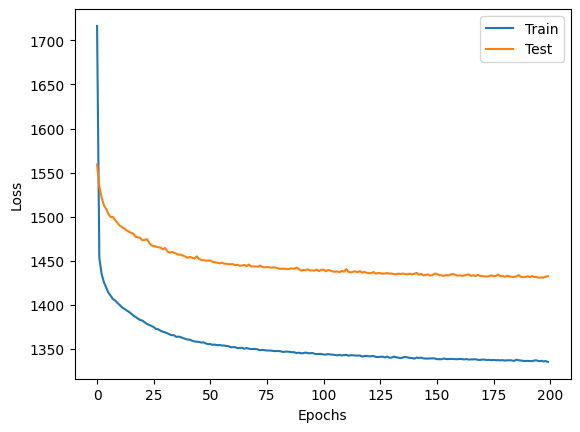

In [296]:
#plot the loss with respect to the epochs
plt.plot(loss_train, label='Train')
plt.plot(loss_test, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [301]:
#plot reconstructed images 
def plot_reconstructions(model, n_images=5):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_dataloader))
        data = data.cpu().numpy()
        data = (data - data.mean())/data.std()
        data = torch.from_numpy(data)
        data = torch.clamp(data, 0, 1)
        data = data.to(device)
        recon, _, _ = model(data)
        recon = recon.cpu()
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(10,4))
    for images, row in zip([data, recon], axes):
        for img, ax in zip(images, row):
            img = img.cpu().numpy()
            ax.imshow(img, cmap='gray')
            #ax.get_xaxis().set_visible(False)
            #ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)
    return recon


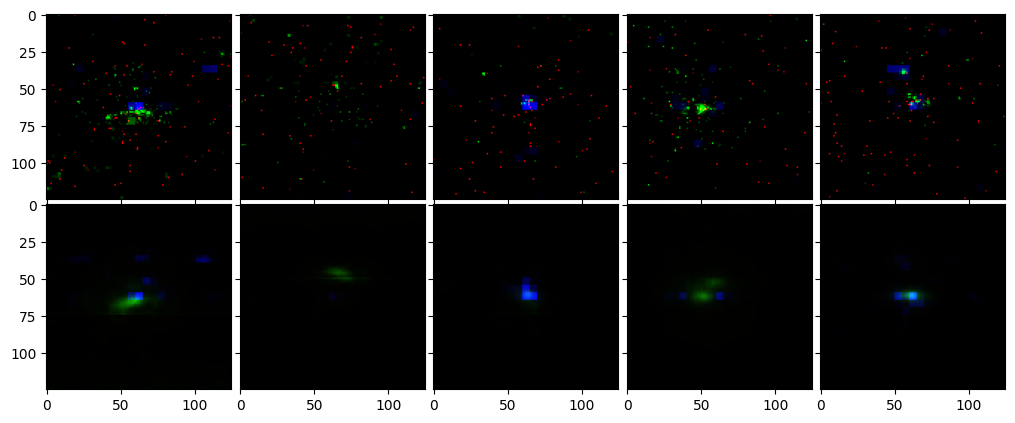

In [302]:
k = plot_reconstructions(model)